# Baigiamasis projektas

### Darbą atliko: Arūnas Bekintis

# Darbo pavadinimas: Kickstarter duomenų bazės analizė

Šią duomenų bazę galima parsisiųsti iš čia (201801 versija):
    https://www.kaggle.com/kemical/kickstarter-projects.
Ši duomenų bazė susideda iš 378661 eilutės ir 15 stulpelių.
Joje yra sukaupta informacija apie Kickstarter projektus, jų (ne-)sėkmę ir kiek pinigų buvo (ne-)sukaupta jiems įgyvendinti.
Kickstarter'is, tai toks projektas, kurį galima pradėti puslapyje www.kickstarter.com.
Tai yra tarsi naujas būdas pradėti verslą.

### Darbo eiga:

Pradžioj įsikeliam naudojamas bibliotekas ir duomenų bazę, su kuria dirbsim:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

np.set_printoptions(suppress=True)
pd.set_option('display.width', 10000)
pd.set_option('display.max_columns', 15)

filename = 'ks-projects-201801.csv'
df = pd.read_csv(filename, encoding="iso8859_2")

print(df)

                ID                                               name         category main_category currency    deadline     goal             launched  pledged     state  backers country  usd pledged  usd_pledged_real  usd_goal_real
0       1000002330                    The Songs of Adelaide & Abullah           Poetry    Publishing      GBP  2015-10-09   1000.0  2015-08-11 12:12:28      0.0    failed        0      GB          0.0               0.0        1533.95
1       1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   Narrative Film  Film & Video      USD  2017-11-01  30000.0  2017-09-02 04:43:57   2421.0    failed       15      US        100.0            2421.0       30000.00
2       1000004038                                     Where is Hank?   Narrative Film  Film & Video      USD  2013-02-26  45000.0  2013-01-12 00:20:50    220.0    failed        3      US        220.0             220.0       45000.00
3       1000007540  ToshiCapital Rekordz Needs Help to Complete 

Pirmiausia susitvarkom duomenų bazę: tikrinam ar yra null reikšmių.

In [2]:
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

Tada jas ištrinam:

In [3]:
df = df[df['name'].notnull() & df['usd pledged'].notnull()]
df.isnull().sum()

ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

Taip pat pašalinam Kickstarter būsenas (state), kurios mūsų nedomina. Jas pervadinam:

In [4]:
df = df[df['state'].isin(['failed', 'successful'])]
df['state'].replace({'failed': 'Nesekmingi projektai', 'successful': 'Sekmingi projektai'}, inplace=True)
df['state'].value_counts()

Nesekmingi projektai    197611
Sekmingi projektai      133851
Name: state, dtype: int64

Sutvarkom datų duomenų tipą:

In [5]:
df = df.astype({'launched': 'datetime64'})
df = df.astype({'deadline': 'datetime64'})
df[['launched', 'deadline']].dtypes

launched    datetime64[ns]
deadline    datetime64[ns]
dtype: object

Apskaičiuojam laiką iki projekto pabaigos (deadline) ir sukuriam naują stulpelį:

In [6]:
df['laikas_iki_ks_pabaigos'] = df['deadline'] - df['launched']
df['laikas_iki_ks_pabaigos']

0        58 days 11:47:32
1        59 days 19:16:03
2        44 days 23:39:10
3        29 days 20:35:49
5        34 days 10:21:33
               ...       
378654   29 days 01:51:38
378657   26 days 20:24:46
378658   45 days 04:19:30
378659   30 days 05:46:07
378660   27 days 14:52:13
Name: laikas_iki_ks_pabaigos, Length: 331462, dtype: timedelta64[ns]

Susitvarkom stulpelį taip, kad rodytų tik dienas ir dar kartą perziūrim
visą DataFrame:

In [7]:
tik_dienos = df['laikas_iki_ks_pabaigos'].dt.days
df['dienos_iki_ks_pabaigos'] = tik_dienos
df['dienos_iki_ks_pabaigos']
df = df.drop('laikas_iki_ks_pabaigos', axis=1)
print(df)

                ID                                               name         category main_category currency   deadline     goal  ...                 state  backers country  usd pledged usd_pledged_real  usd_goal_real  dienos_iki_ks_pabaigos
0       1000002330                    The Songs of Adelaide & Abullah           Poetry    Publishing      GBP 2015-10-09   1000.0  ...  Nesekmingi projektai        0      GB          0.0              0.0        1533.95                      58
1       1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   Narrative Film  Film & Video      USD 2017-11-01  30000.0  ...  Nesekmingi projektai       15      US        100.0           2421.0       30000.00                      59
2       1000004038                                     Where is Hank?   Narrative Film  Film & Video      USD 2013-02-26  45000.0  ...  Nesekmingi projektai        3      US        220.0            220.0       45000.00                      44
3       1000007540  ToshiCap

Kadangi didžioji dalis duomenų yra iš Amerikos (US), tai likusias šalis pervadinu į 'other':

In [8]:
df['country'] = df['country'].replace(['GB', 'CA', 'AU', 'NO', 'IT', 'DE',
                                       'IE', 'MX', 'ES', 'SE', 'FR', 'NZ',
                                       'CH', 'AT', 'BE', 'DK', 'HK', 'NL',
                                       'LU', 'SG', 'JP'], 'other')

Pirmiausia, man buvo įdomu pažiūrėti kiek buvo sėkmingų ir nesėkmingų projektų:

([<matplotlib.patches.Wedge at 0x21b28f638e0>,
 [Text(-1.0999836499358706, -0.005997488954565789, 'Nesekmingi projektai'),
  Text(1.1999821635664043, 0.006542715223161999, 'Sekmingi projektai')],
 [Text(-0.6999895954137358, -0.0038165838801782286, '59.6%'),
  Text(0.7999881090442695, 0.004361810148774665, '40.4%')])

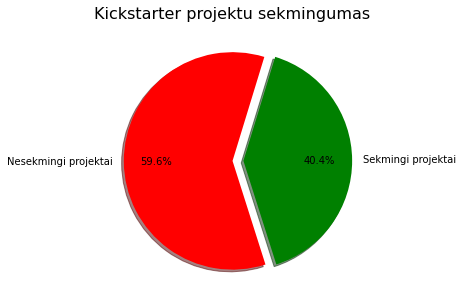

In [9]:
plt.figure(figsize=(7.5, 5))
plt.title('Kickstarter projektu sekmingumas', fontsize=16)
plt.pie(x=df['state'].value_counts(),
        labels=df['state'].value_counts().index,
        autopct='%1.1f%%', pctdistance=0.7,
        explode=(0, 0.1), startangle=73,
        shadow=True, colors={'red', 'green'})

Tada pažiūrėjau kokių kategorijų projektai yra populiariausi:

[Text(0, 0.5, '')]

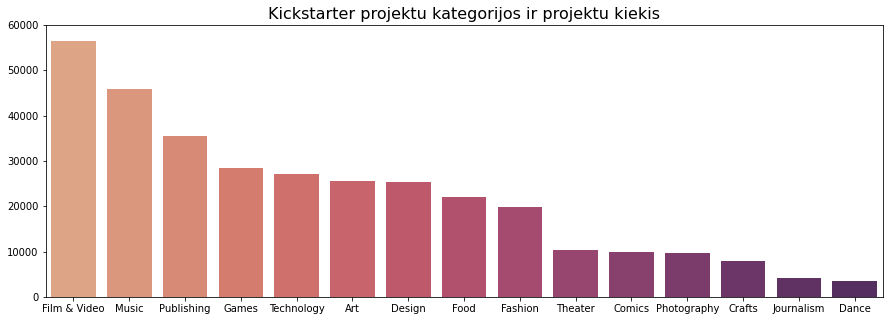

In [10]:
plt.figure(figsize=(15, 5))
plt.title('Kickstarter projektu kategorijos ir projektu kiekis', fontsize=16)
plt.ylim(0, 60000)
sns.barplot(x=df['main_category'].value_counts().index,
            y=df['main_category'].value_counts(),
            palette='flare').set(ylabel=None)

Suskirsčiau projektus pagal šalis:

[Text(0, 0.5, '')]

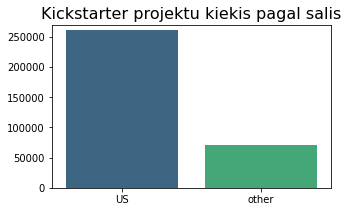

In [11]:
plt.figure(figsize=(5, 3))
plt.title('Kickstarter projektu kiekis pagal salis', fontsize=16)
plt.ylim(0, 270000)
sns.barplot(x=df['country'].value_counts().index,
            y=df['country'].value_counts(),
            palette='viridis').set(ylabel=None)

Pagal pinigų sumą:

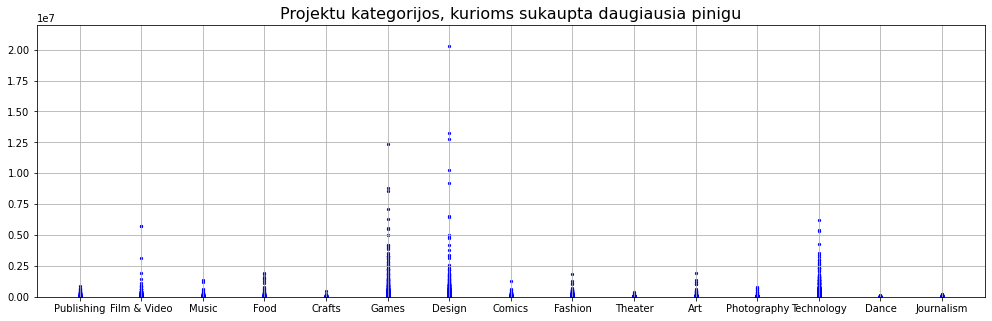

In [12]:
plt.figure(figsize=(17, 5))
plt.title('Projektu kategorijos, kurioms sukaupta daugiausia pinigu', fontsize=16)
plt.ylim(0, 22000000)
plt.scatter(df['main_category'], df['usd_pledged_real'], s=5, c='blue')
plt.grid()

Norėjau sužinoti kiek vidutiniškai gyvuoja projektai. Tam nubraižiau 2 grafikus:

1:

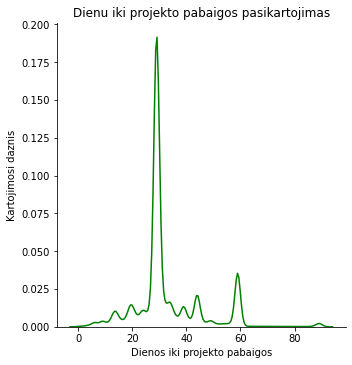

In [13]:
ax1 = sns.displot(x='dienos_iki_ks_pabaigos', data=df, kind='kde', color='green')
ax1.set(xlabel='Dienos iki projekto pabaigos', ylabel='Kartojimosi daznis',
       title='Dienu iki projekto pabaigos pasikartojimas')

2:

[Text(0.5, 0, 'Dienos iki projekto pabaigos'),
 Text(0.5, 1.0, 'Dienu iki projekto pabaigos pasikartojimas')]

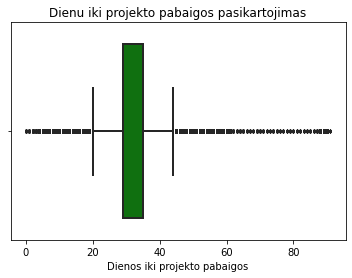

In [14]:
ax2 = sns.boxplot(x='dienos_iki_ks_pabaigos', data=df, color='green', linewidth=2, fliersize=2)
ax2.set(xlabel='Dienos iki projekto pabaigos',
       title='Dienu iki projekto pabaigos pasikartojimas')

Kadangi pamačiau dienų pasiskirstymą, tai nubraižiau ir žmonių (backers) pasiskirstymą:

[Text(0.5, 0, 'Projektams aukojanciu zmoniu kiekis'),
 Text(0.5, 1.0, 'Projektams aukojanciu zmoniu pasiskirstymas')]

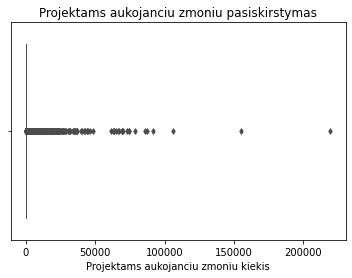

In [15]:
ax3 = sns.boxplot(x='backers', data=df, color='blue', linewidth=1, fliersize=4)
ax3.set(xlabel='Projektams aukojanciu zmoniu kiekis',
       title='Projektams aukojanciu zmoniu pasiskirstymas')

Iš aukščiau nubraižytų grafikų, pastebėjau, kad yra keletas projektų (duomenų), kurie labai įtakoja bendrą vaizdą.
Dėl to nusprendžiau juos nufiltruoti. Taip pat, apskaičiuoju vidutinį aukotų pinigų kiekį ir jį suskirstau pagal kategorijas:

In [16]:
df = df[df['backers'] < np.percentile(df['backers'], 97)]
df = df[(df['usd_pledged_real'] > np.percentile(df['usd_pledged_real'], 2)) &
        (df['usd_pledged_real'] < np.percentile(df['usd_pledged_real'], 98))]
df['Average_pledge'] = df.groupby(df['main_category'])['usd_pledged_real'].transform('mean')

Dabar galim žvilgtelt kaip tai įtakojo grafikus:

[Text(0, 0.5, '')]

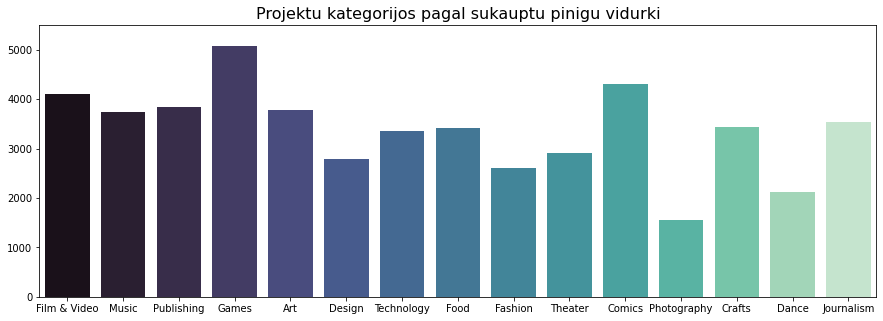

In [17]:
plt.figure(figsize=(15, 5))
plt.title('Projektu kategorijos pagal sukauptu pinigu vidurki', fontsize=16)
plt.ylim(0, 5500)
sns.barplot(x=df['main_category'].value_counts().index,
            y=df['Average_pledge'].unique(),
            palette='mako').set(ylabel=None)

[Text(0.5, 0, 'Projektams aukojanciu zmoniu kiekis'),
 Text(0.5, 1.0, 'Projektams aukojanciu zmoniu pasiskirstymas')]

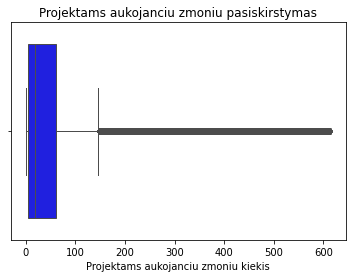

In [18]:
ax3 = sns.boxplot(x='backers', data=df, color='blue', linewidth=1, fliersize=4)
ax3.set(xlabel='Projektams aukojanciu zmoniu kiekis',
       title='Projektams aukojanciu zmoniu pasiskirstymas')

Prieš pradedant braižyti logistinę regresiją, dar kartą sutvarkau duomenis:

In [19]:
df = df.drop('ID', axis=1)
df['state'].replace({'Nesekmingi projektai': '0', 'Sekmingi projektai': '1'}, inplace=True)
df['state'].value_counts()

0    158102
1    118331
Name: state, dtype: int64

Regresijos modelis:

In [20]:
xTrain, xTest, yTrain, yTest = train_test_split(df[['backers',
                                                    'usd_goal_real', 'dienos_iki_ks_pabaigos']],
                                                df['state'], test_size=0.3, random_state=42)
xTrain = sm.add_constant(xTrain)
xTest = sm.add_constant(xTest)

sm_model = sm.Logit(yTrain.astype(float), xTrain.astype(float)).fit()
sm_model.summary()

Optimization terminated successfully.
         Current function value: 0.306398
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:               193503
Model:                          Logit   Df Residuals:                   193503
Method:                           MLE   Df Model:                           -1
Date:                Wed, 16 Dec 2020   Pseudo R-squ.:                  0.5514
Time:                        17:07:18   Log-Likelihood:                -59289.
converged:                       True   LL-Null:                   -1.3215e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.3183      0.020    -16.245      0.000      -0.357      -0.280
backers                    0.0707      0.000    181.424      0.000       0.070       0.071
usd_goal_real             -0.0004    2.5e-06   -153.451      0.000      -0.000      -0.000
dienos_iki_ks_pabaigos    -0.0093      0.001    -16.674      0.000      -0.010      -0.008
==========================================================================================

Possibly complete quasi-separation: A fraction 0.17 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Koreliacija:

In [21]:
df.corr()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,dienos_iki_ks_pabaigos,Average_pledge
goal,1.000000,0.011390,-0.011984,-0.005447,-0.006136,0.945664,0.022172,0.005394
pledged,0.011390,1.000000,0.441854,0.478641,0.572171,-0.003495,-0.000864,0.077367
backers,-0.011984,0.441854,1.000000,0.692138,0.774127,-0.011610,-0.041114,0.122097
usd pledged,-0.005447,0.478641,0.692138,1.000000,0.894626,-0.004275,0.005914,0.110859
usd_pledged_real,-0.006136,0.572171,0.774127,0.894626,1.000000,-0.005451,-0.007137,0.125920
usd_goal_real,0.945664,-0.003495,-0.011610,-0.004275,-0.005451,1.000000,0.022707,0.005007
dienos_iki_ks_pabaigos,0.022172,-0.000864,-0.041114,0.005914,-0.007137,0.022707,1.000000,0.029385
Average_pledge,0.005394,0.077367,0.122097,0.110859,0.125920,0.005007,0.029385,1.000000


<AxesSubplot:>

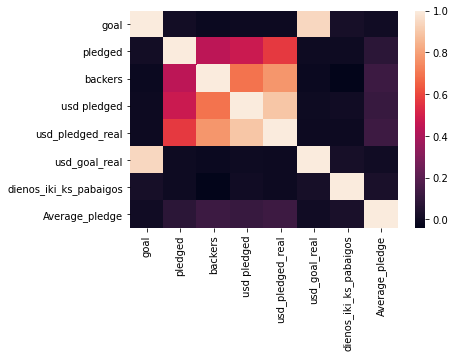

In [22]:
sns.heatmap(df.corr())

Taip pat pavaizdavau Confusion Matrix:

In [23]:
y_estimates = round(sm_model.predict(xTest))
confusion_matrix(yTest.astype(float), y_estimates.astype(float), normalize='pred')

array([[0.90040876, 0.08512941],
       [0.09959124, 0.91487059]])

Accuracy score:

In [24]:
accuracy_score(yTest.astype(float), y_estimates.astype(float))

0.9062100566743037

Recall score:

In [25]:
recall_score(yTest.astype(float), y_estimates.astype(float), average=None)

array([0.94044039, 0.86020746])

Precision score:

In [26]:
precision_score(yTest.astype(float), y_estimates.astype(float), average=None)

array([0.90040876, 0.91487059])

Regresijos modelis, užrašytas kitaip:

In [27]:
X = df[['dienos_iki_ks_pabaigos', 'usd_goal_real', 'backers']]
Y = df['state']
train = df[:(int((len(df)*0.3)))]
test = df[(int((len(df)*0.3))):]
Log1 = LogisticRegression()
train_x = np.array(train[['dienos_iki_ks_pabaigos', 'usd_goal_real', 'backers']])
train_y = np.array(train['state'])
Log1.fit(train_x, train_y)
test_x = np.array(test[['dienos_iki_ks_pabaigos', 'usd_goal_real', 'backers']])
test_y = np.array(test['state'])
#spejimas
state_pred = Log1.predict(test_x)
R = r2_score(test_y, state_pred)
print('R: ', R)

R:  0.6297077646194978


KNN modelis:

In [28]:
xTrain, xTest, yTrain, yTest = train_test_split(df[['dienos_iki_ks_pabaigos',
                                                'usd_goal_real', 'backers']],
                                                df['state'], test_size=0.3, random_state=100)
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(xTrain, yTrain)
yPred = knn.predict(xTest)
conf_m = confusion_matrix(yTest, yPred)
tikslumas = (conf_m[1, 0]+conf_m[0, 1])/(conf_m.sum())
print(tikslumas)

0.12643193054383214


Decision tree modelis:

In [29]:
xTrain, xTest, yTrain, yTest = train_test_split(df[['dienos_iki_ks_pabaigos',
                                                'usd_goal_real', 'backers']],
                                                df['state'], test_size=0.3, random_state=100)
model = DecisionTreeClassifier(max_depth=3)
model.fit(xTrain, yTrain)

yPred = model.predict(xTest)
conf_m = confusion_matrix(yTest, yPred)
tikslumas = (conf_m[1, 0]+conf_m[0, 1])/(conf_m.sum())
print(tikslumas)

0.1196792475581816


[Text(167.4, 190.26, 'X[2] <= 17.5\ngini = 0.49\nsamples = 193503\nvalue = [110584, 82919]'),
 Text(83.7, 135.9, 'X[1] <= 758.895\ngini = 0.192\nsamples = 94699\nvalue = [84512, 10187]'),
 Text(41.85, 81.53999999999999, 'X[2] <= 6.5\ngini = 0.498\nsamples = 14722\nvalue = [7801, 6921]'),
 Text(20.925, 27.180000000000007, 'gini = 0.328\nsamples = 8470\nvalue = [6719, 1751]'),
 Text(62.775000000000006, 27.180000000000007, 'gini = 0.286\nsamples = 6252\nvalue = [1082, 5170]'),
 Text(125.55000000000001, 81.53999999999999, 'X[2] <= 10.5\ngini = 0.078\nsamples = 79977\nvalue = [76711, 3266]'),
 Text(104.625, 27.180000000000007, 'gini = 0.026\nsamples = 66409\nvalue = [65519, 890]'),
 Text(146.475, 27.180000000000007, 'gini = 0.289\nsamples = 13568\nvalue = [11192, 2376]'),
 Text(251.10000000000002, 135.9, 'X[1] <= 15589.72\ngini = 0.388\nsamples = 98804\nvalue = [26072, 72732]'),
 Text(209.25, 81.53999999999999, 'X[2] <= 34.5\ngini = 0.287\nsamples = 81638\nvalue = [14193, 67445]'),
 Text(18

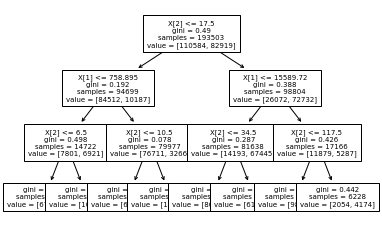

In [30]:
plot_tree(model, fontsize=7)

Random Forest:

In [31]:
xTrain, xTest, yTrain, yTest = train_test_split(df[['dienos_iki_ks_pabaigos',
                                                'usd_goal_real', 'backers']],
                                                df['state'], test_size=0.3, random_state=100)
model = RandomForestClassifier(max_depth=3)
model.fit(xTrain, yTrain)

yPred = model.predict(xTest)
conf_m = confusion_matrix(yTest, yPred)
tikslumas = (conf_m[1, 0]+conf_m[0, 1])/(conf_m.sum())
print(tikslumas)

0.1248522850596889


Funkcija, spėti ar projektas bus sėkmingas:

In [32]:
def speti():
    X = df[['dienos_iki_ks_pabaigos', 'usd_goal_real', 'backers']]
    Y = df['state']
    Log1 = LogisticRegression()
    Log1.fit(X, Y)
    t = input('Iveskite dienas iki projekto pabaigos: ')
    t2 = int(t)
    u = input('Iveskite reikalinga sukaupti pinigu suma: ')
    u2 = int(u)
    g = input('Iveskite reikalinga backers kieki: ')
    g2 = int(g)
    new = [[t2, u2, g2]]
    out = Log1.predict(new)
    return print('Dienos: ' + str(t2) + ', pinigu suma: ' + str(u2) + ', backers: ' +
                 str(g2) + '. Projekto sekme: ' + str(out) + ' (1 - sekmingas, '
                                                             '0 - ne).')

Išbandom:

In [33]:
speti()

Iveskite dienas iki projekto pabaigos: 20
Iveskite reikalinga sukaupti pinigu suma: 20000
Iveskite reikalinga backers kieki: 30
Dienos: 20, pinigu suma: 20000, backers: 30. Projekto sekme: ['0'] (1 - sekmingas, 0 - ne).


### Išvados ir pastebėjimai:

- iš visų 300,000+ projektų, daugiau nei pusė buvo nesėkmingi
- nors populiariausia kategorija yra "Film & Video", tai nėra kategorija su brangiausiais projektais
- didžioji dalis duomenų sukaupta iš Amerikos rinkos
- didžioji dalis projektų tampa sėkmingi (arba ne) per 25-35 dienas
- projektams aukojančių žmonių (backers) kiekis tiesiogiai susijęs su projektų (ne-)sėkme,
todėl, kad nemažai projektų nesulaukė susidomėjimo (0 backers)
- pašalinus projektus, kurie turėjo didžiulės įtakos duomenims, pastebėjome, kad daugumos projektų
kaina neviršija net 35,000. Taip pat, jiems aukoja ne daugiau kaip 150 žmonių.